In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from env import *

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_connection(db, user=user, host=host, password=password):
    '''
    This function uses my info from my env file to
    create a connection url to access the Codeup db.
    It takes in a string name of a database as an argument.
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

In [3]:
# Acquiring our data
def get_iris_data():
    '''
    This function reads the iris data from the Codeup db into a df.
    '''
    sql_query = """
                SELECT 
                    species_id,
                    species_name,
                    sepal_length,
                    sepal_width,
                    petal_length,
                    petal_width
                FROM measurements
                JOIN species USING(species_id)
                """
    
    # Read in DataFrame from Codeup db.
    df = pd.read_sql(sql_query, get_connection('iris_db'))
    return df

df = get_iris_data()

df["sepal_area"] = df.sepal_length * df.sepal_width
df["petal_area"] = df.petal_length * df.petal_width

In [4]:
train_validate, test = train_test_split(df, train_size=.80, random_state=1349)
train, validate = train_test_split(train_validate, random_state=1349)

train.shape, validate.shape, test.shape

((90, 8), (30, 8), (30, 8))

In [5]:
train.head()

,species_id,species_name,sepal_length,sepal_width,petal_length,petal_width,sepal_area,petal_area
115,3,virginica,6.4,3.2,5.3,2.3,20.48,12.19
80,2,versicolor,5.5,2.4,3.8,1.1,13.20,4.18
4,1,setosa,5.0,3.6,1.4,0.2,18.00,0.28
86,2,versicolor,6.7,3.1,4.7,1.5,20.77,7.05
20,1,setosa,5.4,3.4,1.7,0.2,18.36,0.34


In [6]:
train.drop(columns=['species_id'],inplace=True)

In [7]:
# Scale the datasets
scaler = MinMaxScaler()
cols = train.drop(columns=["species_name"]).columns.tolist()

# .copy() makes a proper copy
# this is an alternative to wrapping the scaled numpy array in a pd.Dataframe()
train_scaled = train.copy()
validate_scaled = validate.copy()
test_scaled = test.copy()

# apply our scaler (fit only on train!)
train_scaled[cols] = scaler.fit_transform(train[cols])
validate_scaled[cols] = scaler.transform(validate[cols])
test_scaled[cols] = scaler.transform(test[cols])

In [8]:
# Fit K-Means (just on train, again!)
X = train_scaled[["sepal_area", "petal_area"]]
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

train_scaled['cluster'] = kmeans.predict(X)
train_scaled.head()

,species_name,sepal_length,sepal_width,petal_length,petal_width,sepal_area,petal_area,cluster
115,virginica,0.583333,0.500000,0.724138,0.916667,0.523477,0.766497,0
80,versicolor,0.333333,0.166667,0.465517,0.416667,0.159840,0.258249,2
4,setosa,0.194444,0.666667,0.051724,0.041667,0.399600,0.010787,1
86,versicolor,0.666667,0.458333,0.620690,0.583333,0.537962,0.440355,2
20,setosa,0.305556,0.583333,0.103448,0.041667,0.417582,0.014594,1


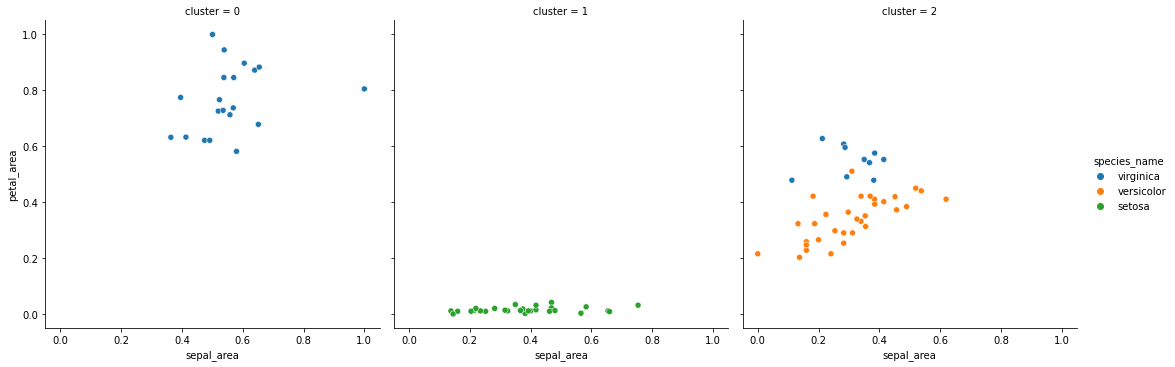

In [9]:
# visualize w/ hue="species" style="cluster"
sns.relplot(x="sepal_area", y="petal_area", hue="species_name", col="cluster", data=train_scaled)
plt.show()

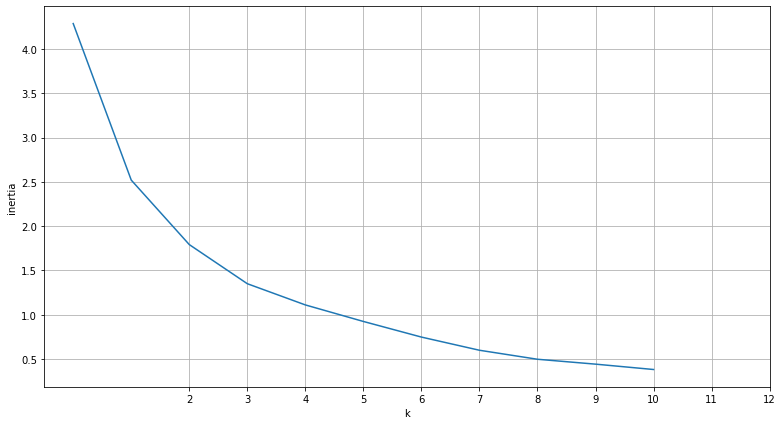

In [10]:
def get_inertia(k):
    return KMeans(k).fit(X).inertia_

plt.figure(figsize=(13, 7))

df = pd.Series([get_inertia(k) for k in range(2, 13)]).plot()

plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(range(2, 13))
plt.grid()

In [11]:
train_scaled.head()

,species_name,sepal_length,sepal_width,petal_length,petal_width,sepal_area,petal_area,cluster
115,virginica,0.583333,0.500000,0.724138,0.916667,0.523477,0.766497,0
80,versicolor,0.333333,0.166667,0.465517,0.416667,0.159840,0.258249,2
4,setosa,0.194444,0.666667,0.051724,0.041667,0.399600,0.010787,1
86,versicolor,0.666667,0.458333,0.620690,0.583333,0.537962,0.440355,2
20,setosa,0.305556,0.583333,0.103448,0.041667,0.417582,0.014594,1


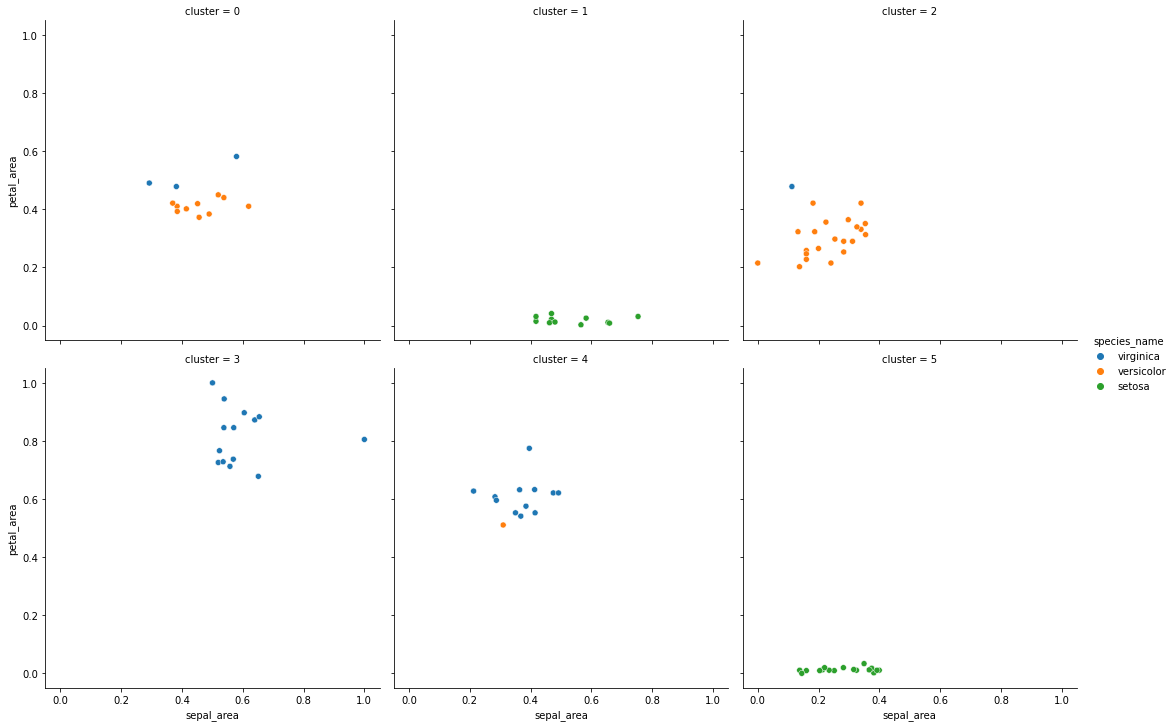

In [12]:
# Fit K-Means
X = train_scaled[["sepal_area", "petal_area", "sepal_length", "petal_width"]]
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)

train_scaled['cluster'] = kmeans.labels_

# visualize w/ hue="species" style="cluster"
sns.relplot(x="sepal_area", y="petal_area", hue="species_name", col="cluster", col_wrap=3, data=train_scaled)
plt.show()

## Clustering Mall Data

In [13]:
import env
# build a simple query:
db_name = "mall_customers"
query = 'SELECT * FROM customers'

url  = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/{db_name}'
df = pd.read_sql(query, url, index_col="customer_id")

# Encode gender
df.gender = df.gender.apply(lambda x: 1 if x == "Female" else 0)

# Split nice and early
train_validate, test = train_test_split(df, train_size=.80, random_state=123)
train, validate = train_test_split(train_validate, random_state=123)

train.shape, validate.shape, test.shape

train.head()

,gender,age,annual_income,spending_score
customer_id,,,,
64,1,54,47,59
49,1,29,40,42
25,1,54,28,14
137,1,44,73,7
177,0,58,88,15


In [14]:
# Scale the datasets

# Start w/ empty copies to retain the original splits
train_scaled = train.copy()
validate_scaled = validate.copy()
test_scaled = test.copy()

# Scale the datasets
scaler = MinMaxScaler()
cols = train.drop(columns=["gender"]).columns.tolist()

train_scaled[cols] = scaler.fit_transform(train[cols])
validate_scaled[cols] = scaler.transform(validate[cols])
test_scaled[cols] = scaler.transform(test[cols])

# Add back in the gender column to the dataframes
train_scaled["gender"] = train.gender.copy()
validate_scaled["gender"] = validate.gender.copy()
test_scaled["gender"] = test.gender.copy()

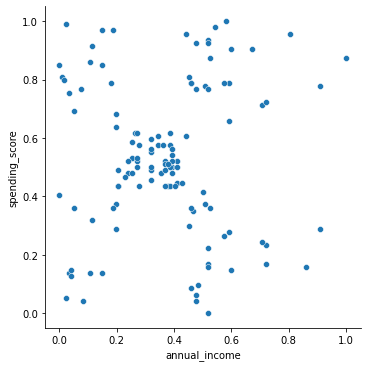

In [15]:
sns.relplot(x="annual_income", y="spending_score", data=train_scaled)
plt.show()

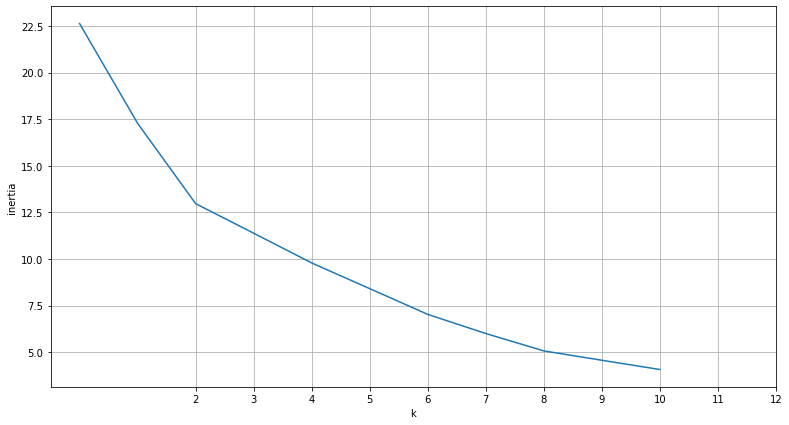

In [16]:
X = train_scaled.copy()

def get_inertia(k):
    return KMeans(k).fit(X).inertia_

plt.figure(figsize=(13, 7))
df = pd.Series([get_inertia(k) for k in range(2, 13)]).plot()

plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(range(2, 13))
plt.grid()

In [17]:
# Looks like the sweet spot is 4, 5, or 6
# Let's start with and visualize kmeans clusters w/ k=5

# Fit K-Means
X = train_scaled.copy()
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

train_scaled['cluster'] = kmeans.labels_

train_scaled.head()

,gender,age,annual_income,spending_score,cluster
customer_id,,,,,
64,1,0.692308,0.262295,0.617021,1
49,1,0.211538,0.204918,0.436170,4
25,1,0.692308,0.106557,0.138298,1
137,1,0.500000,0.475410,0.063830,1
177,0,0.769231,0.598361,0.148936,0


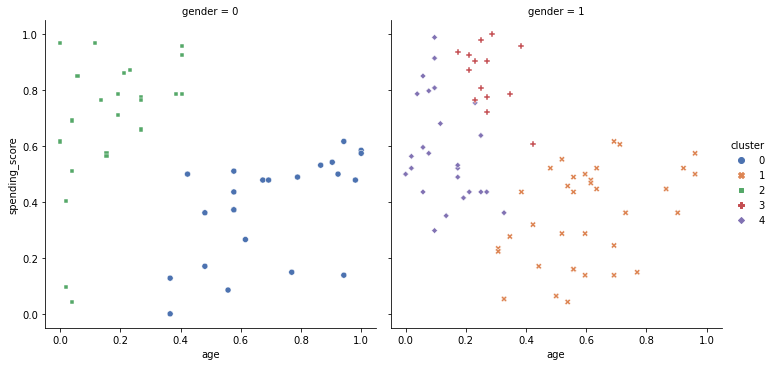

In [18]:
# One column per gender value
# One color/shape for each cluster label
sns.relplot(x="age", y="spending_score", style="cluster", hue="cluster", col="gender", palette="deep", data=train_scaled)
plt.show()

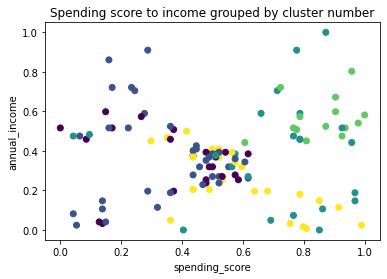

In [19]:
plt.title("Spending score to income grouped by cluster number")
plt.scatter(train_scaled.spending_score, train_scaled.annual_income, c=train_scaled.cluster)
plt.xlabel("spending_score")
plt.ylabel("annual_income")
plt.show()

In [20]:
# Looks like the sweet spot is 4, 5, or 6
# Let's start with and visualize kmeans clusters w/ k=4

# Fit K-Means
X = train_scaled.copy()
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)

train_scaled['cluster'] = kmeans.labels_

train_scaled.head()

,gender,age,annual_income,spending_score,cluster
customer_id,,,,,
64,1,0.692308,0.262295,0.617021,1
49,1,0.211538,0.204918,0.436170,0
25,1,0.692308,0.106557,0.138298,1
137,1,0.500000,0.475410,0.063830,1
177,0,0.769231,0.598361,0.148936,3


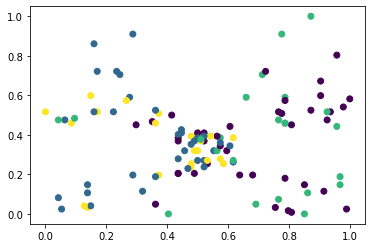

In [21]:
plt.scatter(train_scaled.spending_score, train_scaled.annual_income, c=train_scaled.cluster)
plt.show()

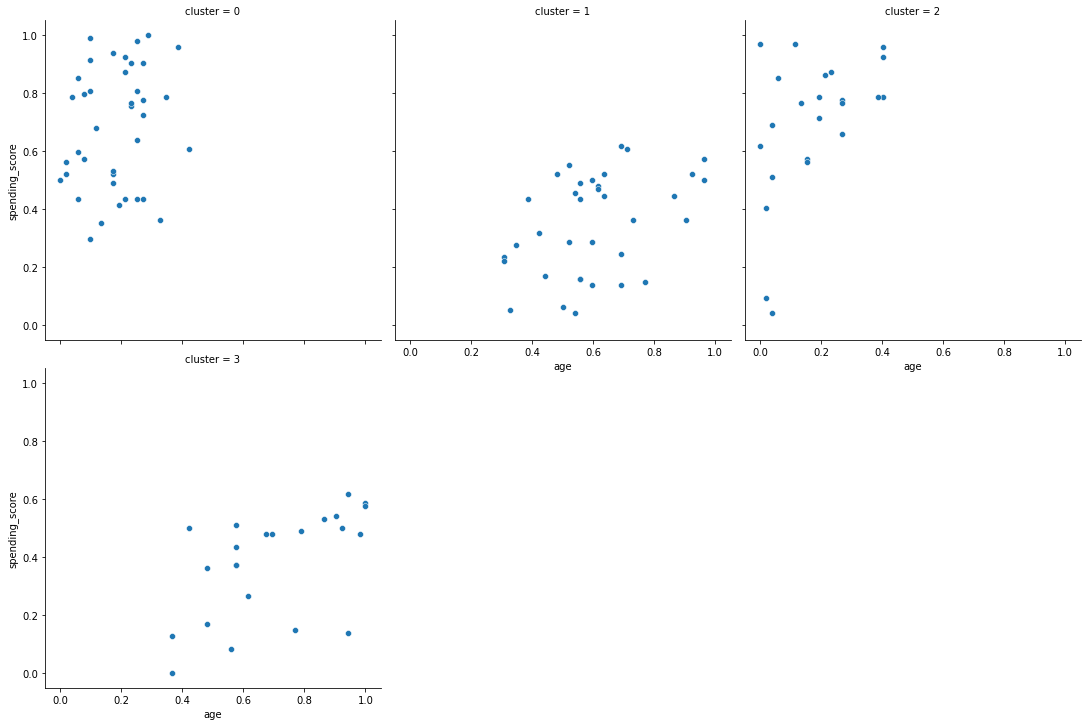

In [22]:
# One column per gender value
# One color/shape for each cluster label
sns.relplot(x="age", y="spending_score", col="cluster", col_wrap=3, data=train_scaled)

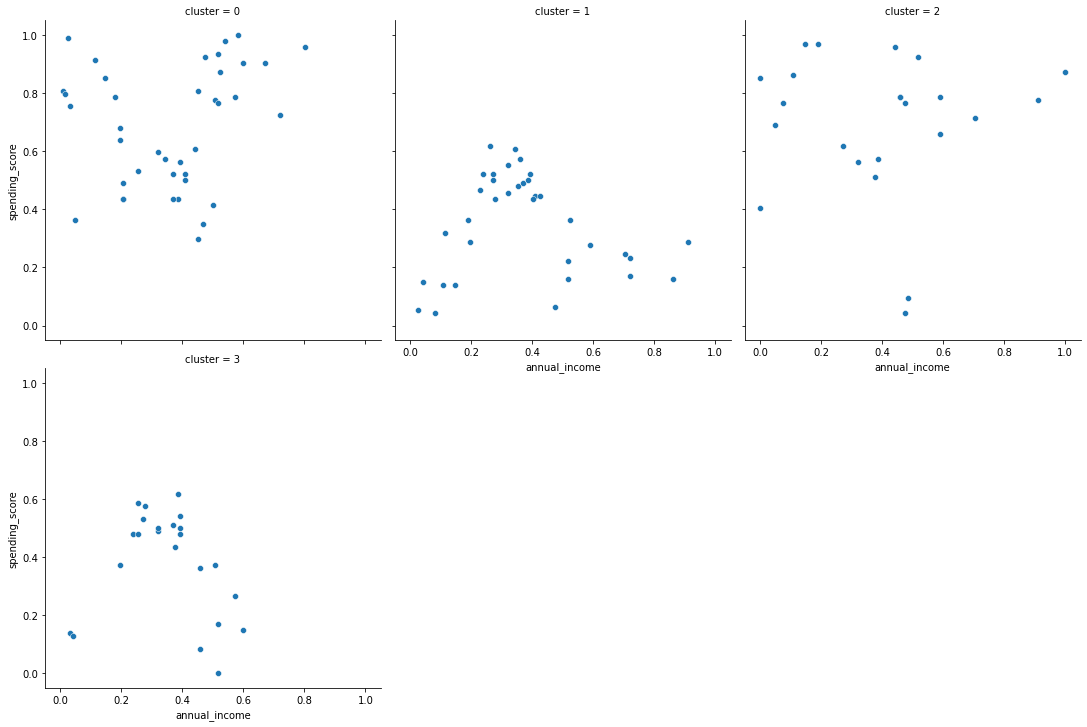

In [23]:
# One column per gender value
# One color/shape for each cluster label
sns.relplot(x="annual_income", y="spending_score", col="cluster", col_wrap=3, data=train_scaled)
plt.show()

## Comparing scaled clusters and unscaled clusters

In [24]:
train.describe()

,gender,age,annual_income,spending_score
count,120.000000,120.000000,120.000000,120.000000
mean,0.616667,38.900000,60.166667,50.816667
std,0.488237,14.637008,25.937330,24.240040
min,0.000000,18.000000,15.000000,1.000000
25%,0.000000,27.000000,40.000000,35.000000
50%,1.000000,36.500000,61.500000,49.500000
75%,1.000000,49.000000,77.000000,73.000000
max,1.000000,70.000000,137.000000,95.000000


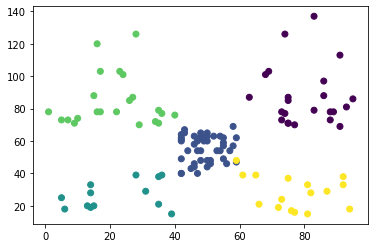

In [25]:
# We'll use annual income and spending score this time since they had those lumps

# Fit K-Means
X = train.copy()
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

train['cluster'] = kmeans.labels_
plt.scatter(train.spending_score, train.annual_income, c=train.cluster)
plt.show()

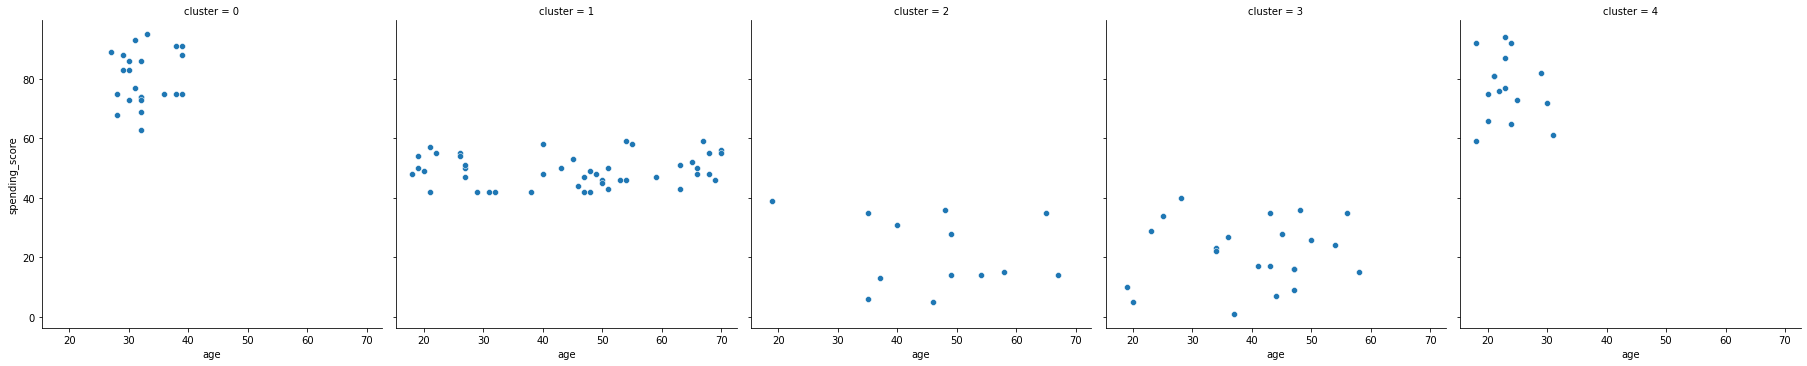

In [26]:
sns.relplot(x="age", y="spending_score", col="cluster", data=train)
plt.show()

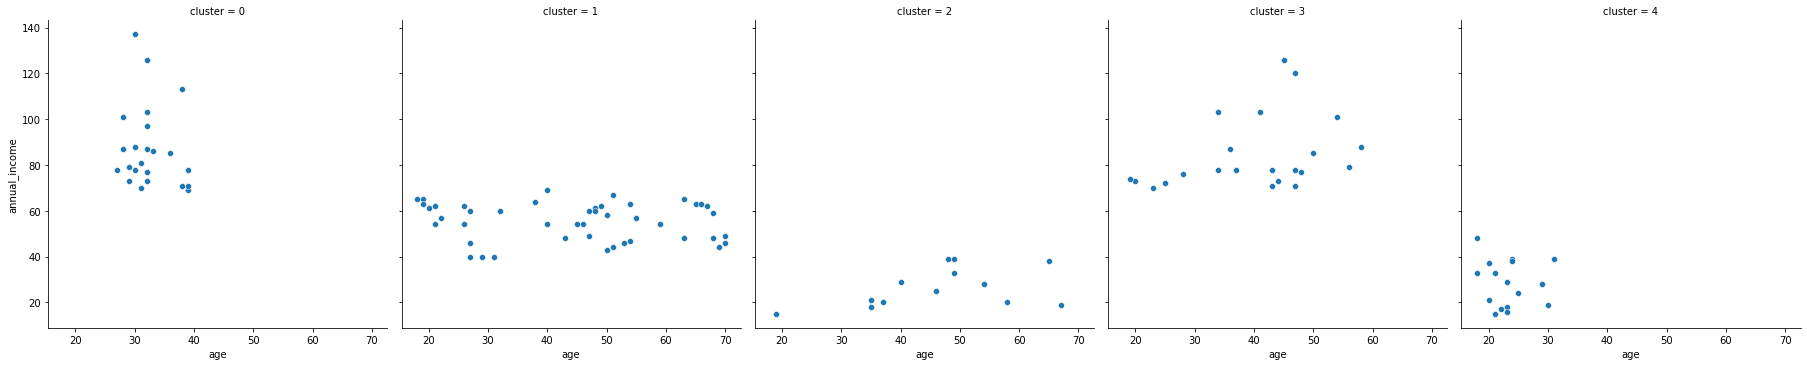

In [27]:
sns.relplot(x="age", y="annual_income", col="cluster", data=train)
plt.show()

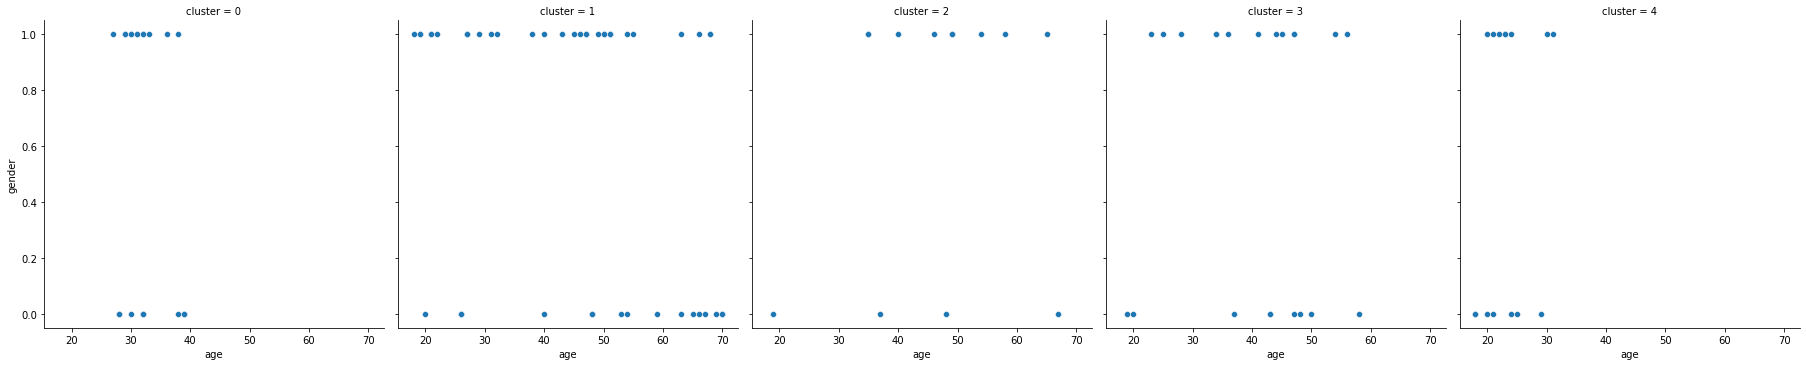

In [28]:
sns.relplot(x="age", y="gender", col="cluster", data=train)
plt.show()

### Takeaways:

#### Cluster 0:
- average spenders who could afford more
- spending scores in the 40-60 range
- no noticable difference in age/gender
- 64% women, 36% men
- 25-40 year old males are not present

#### Cluster 1:
- low spenders
- bottom quarter of income
- bottom 40% of spending scores
- 2/3rds women, 1/3 men

#### Cluster 2:
- bottom half of spending ratio
- top half of income 
- gender/age evenly distributed
- save money or funding customers in cluster 3

#### Cluster 3:
- top half of spending scores
- ages up to 30
- income is low
- gender is even

#### Cluster 4:
- top half of spending score
- top half of income score
- age range 28-40
- 2/3rds women and 1/3 men